In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import yfinance as yf
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from math import ceil
from sklearn import metrics

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
#from keras.models import Sequential
#from keras.layers import LSTM
#from keras.layers import Dropout
#from keras.layers import Dense
#from keras.layers import TimeDistributed
import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np


In [2]:
def get_data(tickers, start_date, end_date, columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']):
    """
    Obs:
    The function gets the Adjusted Close price for the tickers within the dates informed
    
    Input: 
    
    tickers: list of tickers to get
    start_data: data format like "aaaa-mm-dd". Necessary use a valid trade day
    end_data: data format like "aaaa-mm-dd". Necessary use a valid trade day
    columns: desired columns to get from yfinance (Open, High, Low, Close, Volume)

    Output:
    dataframe with the adjusted close price for the tickers and dates informed. 
    
    """
    
    #
    
        
    df = yf.download(tickers, start=start_date, end=end_date)[columns]
   
    return df



def norm(df, start, end):
    df = df.loc[start:end]
    norm_df = df / df.iloc[0,:]
    return norm_df




def rolling_mean(df, window):
    """
    Obs:
    The function gets the simple moving average for each ticker
    
    Input: 
    
    df: dataframe with stock prices
    tickers: list of tickers

    Output:
    dataframe the simple moving average for each ticker
    
    """    
    sma = df.rolling(window=window).mean()
    return sma 



def rolling_std(df, window):
    """
    Obs:
    The function gets the simple moving average for each ticker
    
    Input: 
    
    df: dataframe with stock prices
    tickers: list of tickers
    window: number of days to compose the interval

    Output:
    dataframe the simple moving average for each ticker
    
    """    
    moving_std = df.rolling(window=window).std()
    return moving_std



def bollinger_bands(df, window, number_of_std):
    
    """
    Obs:
    The function returns the Bollinger Bands based on df, ticker, window and number of standard deviation
    
    Input: 
    
    df: dataframe with stock prices
    tickers: list of tickers
    window: number of days to compose the interval
    number_of_std: number of the std for calculate the bollinger bands

    Output:
    sma : simple moving average
    upper_band
    lower_band
    
    """  
    sma = rolling_mean(df, window)
    moving_std = rolling_std(df, window)
    upper_band = sma + moving_std * number_of_std
    lower_band = sma - moving_std * number_of_std
    return sma, upper_band, lower_band



def daily_return(df, periods_to_shift):
    
    """
    Obs:
    The function returns the stock's returns based on the period informed
    
    Input: 
    
    df: dataframe with stock prices
    periods_to_shift: Periods to shift for forming percent change.
    
    Output:
    dataframe with returns based on the period informed
    
    """  
    
    df = df.pct_change(periods = periods_to_shift)
    # check the type of object to do the correct change in the first row 
    if isinstance(df, pd.Series) != True:
        df.iloc[0,:] = 0
    else:
        df[0] = 0
    return df


def train_test_split_custom(data, size):
    
    """
    Obs: this function will split the data in train set and test set accordingly to a chronological order
    
    Input:
    scaled data set
    size: the size of the sample to train the model
    
    
    """
    
    test_size = int(data.shape[0] * size)
    x_train = data[:test_size,0:-1]
    y_train = data[:test_size,-1]
    x_test = data[test_size:,0:-1]
    y_test = data[test_size:,-1]
    return x_train, x_test, y_train, y_test


# ============================================= Plot Functions =================================

def plot_data(df, title, x_label, y_label):
    df.plot(figsize=(15,8))  
    plt.title(title, fontsize='30')
    plt.xlabel(x_label, fontsize='20')
    plt.ylabel(y_label, fontsize='20')
    
    plt.axhline(y=1)   
    plt.axvline(x='2020-03-01', color='red', linestyle='dashed', label='COVID19')
    
    plt.legend(loc='upper right')

    plt.show()



def plot_line(stock):
    """
    Only for individual stocks
    """
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15) 
    
    plt.figure(figsize=(15,8))
    plt.plot(stock, label=stock.name)
    # plot horizontal lines
    plt.axhline(y = 0, color = 'black')
    plt.axhline(y = stock.std(), color = 'orange', linestyle= 'dashed', label='1 std')
    plt.axhline(y = -stock.std(), color = 'orange', linestyle='dashed')
    plt.axhline(y = stock.std() * 2, color = 'r', linestyle= 'dashed', label='2 std')
    plt.axhline(y = -stock.std() * 2, color = 'r', linestyle='dashed')   
    plt.legend(loc='upper right')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.title('Historical Return')
    plt.show()

def plot_hist(d_return):
    d_return.hist(figsize=(15,8), bins=100)
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15) 
    plt.axvline(d_return.mean(), color='w', linestyle='dashed', label='mean')
    plt.axvline(d_return.std(), color='orange', linestyle='dashed', label='1 std')
    plt.axvline(-d_return.std(), color='orange', linestyle='dashed')
    plt.axvline(d_return.std() * 2, color='r', linestyle='dashed', label='2 std')
    plt.axvline(-d_return.std() * 2, color='r', linestyle='dashed')            
    plt.legend(loc='upper right')
    print(f'The Kurtosis is: {d_return.kurtosis()}') # bigger than 0 = Fat Tails    
    
    
def hist_seaborn(d_return):
    sns.set(font_scale=2)
    sns.displot(d_return, kde=True, height=10, aspect=2)
    plt.axvline(d_return.mean(), color='w', linestyle='dashed', label='mean')
    plt.axvline(d_return.std(), color='orange', linestyle='dashed', label='1 std')
    plt.axvline(-d_return.std(), color='orange', linestyle='dashed')
    plt.axvline(d_return.std() * 2, color='r', linestyle='dashed', label='2 std')
    plt.axvline(-d_return.std() * 2, color='r', linestyle='dashed')            
    plt.legend(loc=1, fontsize='20')
    plt.title(f'{d_return.name} Daily Return Distribution')
    print(f'The Kurtosis is: {d_return.kurtosis()}') # bigger than 0 = Fat Tails    

def scatter_searborn(df, x_data, y_data):
    sns.lmplot(data=df, x=x_data, y=y_data,
              height=8, aspect=1.5) 
    
    sns.scatterplot(data=df, x= x_data, y= y_data, s=100)
    beta_y, alpha_y = np.polyfit(d_return[x_data], d_return[y_data], 1)
    plt.plot(d_return[x_data], beta_y * d_return[x_data] + alpha_y, '-', color='r')
    plt.title(f'Relation Between {x_data} and {y_data} Daily Return ')
    print(f'Beta Coeficient between {x_data} and {y_data} is {beta_y}')
    print(f'Alpha Coeficient between {x_data} and {y_data} is {alpha_y}')

    
def series_analysis(series, statistic):
    
    """
    Obs:
    The function returns a visualization of the describe aspects of a df like (count, mean, std, min, 25%, 50%, 75%, max)
    
    Input: 
    
    df: daily return df
    statistic: count, mean, std, min, 25%, 50%, 75%, max
    
    Output:
    bar chart
    
    """     
       
    #statistics_d_return = d_return_df.describe().loc[statistic]
    statistics_d_return = series.sort_values(ascending=False)
    # Get x_axis and y_axis to visualize
    x_axis = statistics_d_return.index
    y_axis = statistics_d_return.values
    # Perform Analysis
    plt.figure(figsize=(19, 8))
    plt.bar(x_axis, y_axis, color='green')
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15) 
    plt.title(f'{statistic} Analysis', fontsize='30')
    plt.xlabel('Stocks',fontsize='20')
    plt.ylabel(f'{statistic} ',fontsize='20')
    plt.show()

# Project Overview

# This project had as a target implement a model capable of predicting stock prices, by taking past data as closing prices and some features based on technical analysis indicators. The data was gathered from Yahoo Finance and the needed data preprocessing was made to remove unnecessary features and drop nan values. Until the accomplish of the proposed task an exploratory analysis had been made with some data visualization to better understand the data. 

## - Some statistics analysed:
### Return
##### - Total Return
##### - Cumulative Return all dataset
##### - Cumulative Return per Sector
##### - Daily Return of all stocks together
### Risk
##### - Daily Stantard Deviation of all stocks together
##### - Daily Return and Standar Deviation ploted in the same line graph and histogram
### Interdependence Relation
##### - Scater plots
##### - Correlation Matrix
### Technical Analysis
##### -Simple Moving Average
##### - Bolinger Bands
### Machine Learn
#### Models
##### - Linear Regression
##### - KNN
##### - LSTM


# Get Data
### The criteria to select stocks was the biggest representations of the majors sectors of S&P 500

In [3]:
""" 

AAPL - Technology: Consumer Electronics
MSFT - Technology: Software Infrastructure
GOOGL - Communication Services: Internet Content
DIS - Communication Services: Entertainment
AMZN - Consumer Cyclical: Internet Retail
TSLA - Consumer Cyclical: Auto Manufacturers
PG - Consumer Defensive: Household & Personal Products
KO - Consumer Defensive: Beverages - Non Alcoholic
JPM - Financial: Banks
MS - Financial: Capital Markets
JNJ - Healthcare: Drug Manufacturers
UNH - Healthcare: Healthcare Plans
XOM - Energy: Oil & Gas
CVX - Energy: Oil & Gas
AMT - Real State: Reit Specialty
PLD - Real State: Reit Industrial
HON - Industrials: Specialty Industrial Machinery
RTX - Industrials: Aerospace & Defense
NEE - Utilities: regulated Electric
LIN - Basic Materials: Speiclaty Chemicals

"""    

stocks = get_data(['SPY','AAPL', 'MSFT','GOOG','DIS', 'AMZN', 'TSLA', 'PG', 'KO','JPM','MS','JNJ','UNH','XOM','CVX', 'AMT',\
                   'PLD','HON','RTX','NEE','LIN'],\
                  '2012-01-01', '2022-10-30','Adj Close')

[*********************100%***********************]  21 of 21 completed


# Take a look at data

In [4]:
stocks.head(5)

,AAPL,AMT,AMZN,CVX,DIS,GOOG,HON,JNJ,JPM,KO,...,MS,MSFT,NEE,PG,PLD,RTX,SPY,TSLA,UNH,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,12.519278,48.222256,8.9515,70.606506,34.300617,16.573130,42.067112,48.390274,25.737318,24.902021,...,12.793268,21.466702,10.921097,48.218838,21.137873,36.132759,103.596176,1.872000,43.510464,54.916359
2012-01-04,12.586559,48.919212,8.8755,70.484955,34.784100,16.644611,42.029247,48.096458,25.900356,24.745810,...,12.681882,21.971893,10.893308,48.197182,20.602915,36.321499,103.758667,1.847333,44.144222,54.929115
2012-01-05,12.726295,49.484997,8.8805,69.794014,35.366077,16.413727,42.074657,48.037697,26.441343,24.628651,...,12.952390,22.196419,11.032251,47.995167,21.137873,35.973038,104.034958,1.808000,44.439991,54.763092
2012-01-06,12.859333,49.403000,9.1305,69.288673,35.733166,16.189817,41.764359,47.619034,26.204193,24.472437,...,12.650055,22.541243,10.915538,47.879723,20.812561,35.764935,103.766815,1.794000,44.600544,54.354401
2012-01-09,12.838935,49.542389,8.9280,70.043541,35.589909,15.503389,42.112503,47.692474,26.159723,24.472437,...,12.888737,22.244539,10.928507,48.081760,20.624603,35.861732,104.018707,1.816667,44.549854,54.597054


In [5]:
#Check the Dtype for each column
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2725 entries, 2012-01-03 to 2022-10-28
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2725 non-null   float64
 1   AMT     2725 non-null   float64
 2   AMZN    2725 non-null   float64
 3   CVX     2725 non-null   float64
 4   DIS     2725 non-null   float64
 5   GOOG    2725 non-null   float64
 6   HON     2725 non-null   float64
 7   JNJ     2725 non-null   float64
 8   JPM     2725 non-null   float64
 9   KO      2725 non-null   float64
 10  LIN     2725 non-null   float64
 11  MS      2725 non-null   float64
 12  MSFT    2725 non-null   float64
 13  NEE     2725 non-null   float64
 14  PG      2725 non-null   float64
 15  PLD     2725 non-null   float64
 16  RTX     2725 non-null   float64
 17  SPY     2725 non-null   float64
 18  TSLA    2725 non-null   float64
 19  UNH     2725 non-null   float64
 20  XOM     2725 non-null   float64
dtypes: float64(21)
memo

In [6]:
# descriptive analysis of adjusted close price
stocks.describe()

,AAPL,AMT,AMZN,CVX,DIS,GOOG,HON,JNJ,JPM,KO,...,MS,MSFT,NEE,PG,PLD,RTX,SPY,TSLA,UNH,XOM
count,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,...,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000
mean,55.401261,138.215083,67.746763,89.608298,102.389169,54.804035,118.776217,107.467812,78.847436,39.220826,...,40.851686,106.822842,38.601567,86.346390,60.905328,63.747801,239.725841,65.003631,198.226643,60.285486
std,47.734953,72.294555,54.259442,22.143142,36.670589,35.721992,51.610377,35.867246,37.391905,9.897050,...,23.059836,89.846412,23.231537,31.411294,36.008318,15.187079,97.472235,99.158408,137.468671,11.231280
min,12.064586,48.222256,8.796500,47.611778,34.300617,13.924059,40.569698,46.225235,23.123503,23.783672,...,9.889568,21.466702,10.891453,43.470364,20.602915,34.717793,103.596176,1.519333,42.547131,26.768915
25%,21.854856,78.534058,17.795000,76.474510,81.816101,27.291073,76.276474,80.530220,46.646038,31.422850,...,24.883451,37.235443,19.887537,62.978245,31.870531,53.870960,168.396973,13.441333,76.025009,56.777618
50%,34.528469,117.268394,47.898499,83.973259,101.101608,46.133499,113.505455,108.737877,76.736221,36.938797,...,36.650700,64.693115,30.896305,73.436783,48.636982,60.987316,218.682083,17.252001,164.843124,60.398148
75%,70.051163,211.671188,99.493500,98.653648,118.269997,67.178001,158.002594,132.238495,101.959999,46.345001,...,46.429718,157.933472,56.157681,112.786224,83.207916,74.688499,292.873322,36.589333,271.670197,64.151337
max,180.959732,295.193634,186.570496,178.598465,201.910004,150.709000,228.017639,182.411423,166.523987,64.799698,...,105.765923,339.924835,91.410133,161.211884,169.552887,103.137672,470.083679,409.970001,549.545959,109.815956


In [7]:
# higher prices
stocks.describe().loc['max'][:3]

AAPL    180.959732
AMT     295.193634
AMZN    186.570496
Name: max, dtype: float64

In [8]:
# lower prices
stocks.describe().loc['min'][:3]

AAPL    12.064586
AMT     48.222256
AMZN     8.796500
Name: min, dtype: float64

In [9]:
# Evaluating if there is null values in the data
stocks.isnull().sum()

AAPL    0
AMT     0
AMZN    0
CVX     0
DIS     0
GOOG    0
HON     0
JNJ     0
JPM     0
KO      0
LIN     0
MS      0
MSFT    0
NEE     0
PG      0
PLD     0
RTX     0
SPY     0
TSLA    0
UNH     0
XOM     0
dtype: int64

# Fill Nan

In [10]:
# Dealing with missing data.
stocks.fillna(method='ffill', inplace=True)
stocks.fillna(method='bfill', inplace=True) # growth companies in general are newer compared to value companies and will need this method 

In [11]:
# Evaluating if there is null values in the data
stocks.isnull().sum()

AAPL    0
AMT     0
AMZN    0
CVX     0
DIS     0
GOOG    0
HON     0
JNJ     0
JPM     0
KO      0
LIN     0
MS      0
MSFT    0
NEE     0
PG      0
PLD     0
RTX     0
SPY     0
TSLA    0
UNH     0
XOM     0
dtype: int64

# Total Return

In [12]:
# Total Return
total_return = (stocks.iloc[-1,:] / stocks.iloc[0,:] -1) * 100 
total_return.sort_values(ascending=False, inplace=True)
total_return

TSLA    12107.265322
UNH      1163.020231
AAPL     1141.941360
AMZN     1055.225430
MSFT      995.683647
NEE       619.988753
MS        542.681760
GOOG      482.750536
PLD       430.930338
JPM       389.872339
HON       384.776137
AMT       324.513544
SPY       273.799280
JNJ       259.056697
LIN       248.367647
DIS       208.886561
PG        180.429823
RTX       161.606784
CVX       152.949019
KO        142.277968
XOM        99.969478
dtype: float64

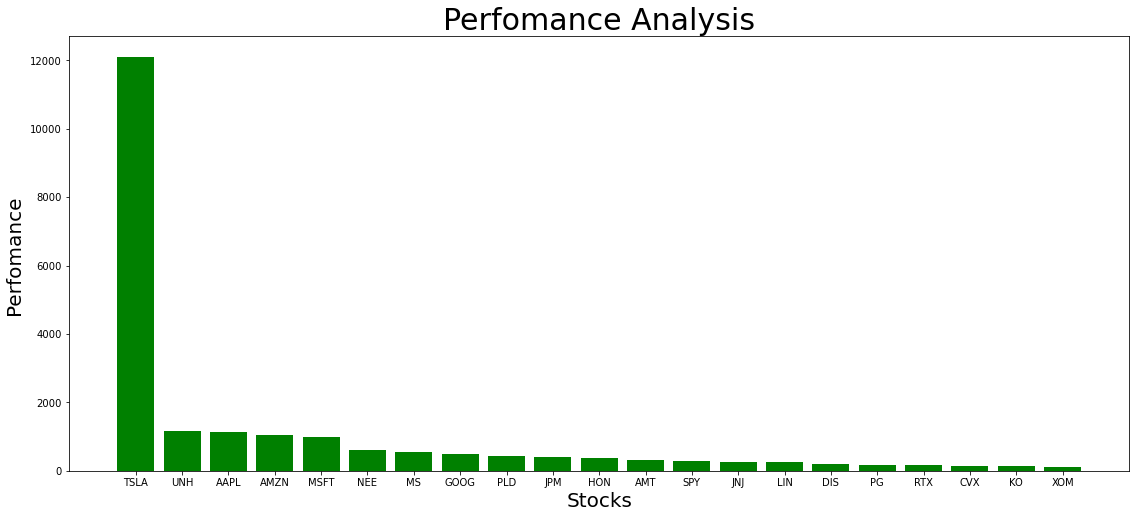

In [13]:
series_analysis(total_return, 'Perfomance')

# Cumulative Return

In [14]:
# Cumulative return between start date and end date
norm_df = norm(stocks, '2002-01-02','2022-01-02')
norm_df.head()

,AAPL,AMT,AMZN,CVX,DIS,GOOG,HON,JNJ,JPM,KO,...,MS,MSFT,NEE,PG,PLD,RTX,SPY,TSLA,UNH,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2012-01-04,1.005374,1.014453,0.991510,0.998278,1.014095,1.004313,0.999100,0.993928,1.006335,0.993727,...,0.991293,1.023534,0.997455,0.999551,0.974692,1.005224,1.001569,0.986823,1.014566,1.000232
2012-01-05,1.016536,1.026186,0.992068,0.988493,1.031062,0.990382,1.000179,0.992714,1.027354,0.989022,...,1.012438,1.033993,1.010178,0.995361,1.000000,0.995580,1.004236,0.965812,1.021363,0.997209
2012-01-06,1.027163,1.024485,1.019997,0.981336,1.041765,0.976871,0.992803,0.984062,1.018140,0.982749,...,0.988806,1.050056,0.999491,0.992967,0.984610,0.989820,1.001647,0.958333,1.025053,0.989767
2012-01-09,1.025533,1.027376,0.997375,0.992027,1.037588,0.935453,1.001079,0.985580,1.016412,0.982749,...,1.007462,1.036235,1.000679,0.997157,0.975718,0.992499,1.004079,0.970442,1.023888,0.994186


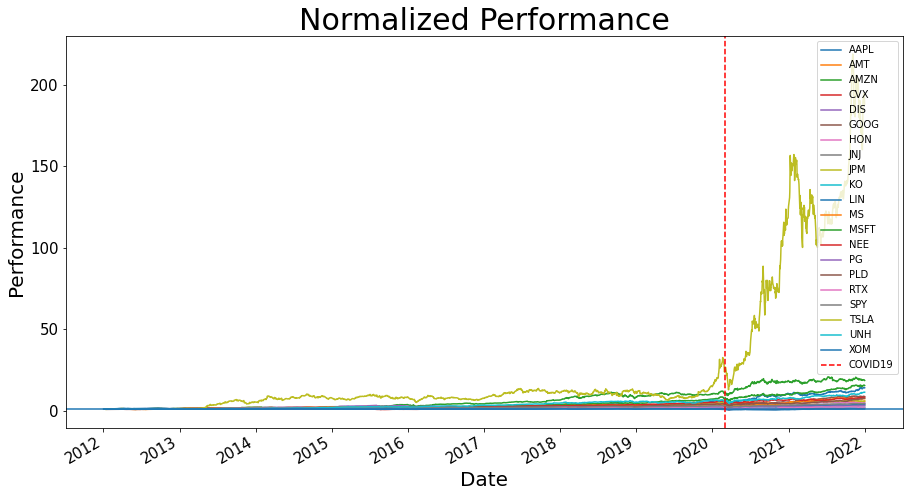

In [15]:
# Normalized cumulative return
plot_data(norm_df, 'Normalized Performance', 'Date', 'Performance')

# Cumulative Return by Sectors

#### Tech and Communication Companies

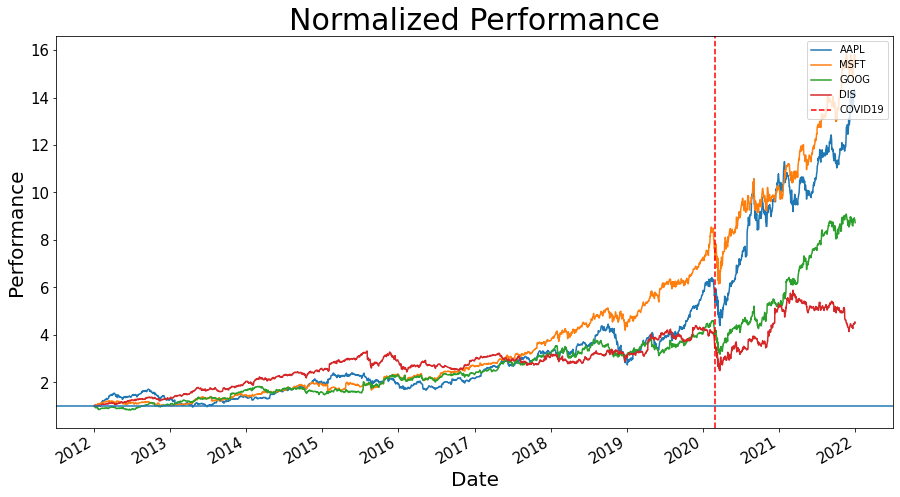

In [16]:
plot_data(norm_df[['AAPL', 'MSFT', 'GOOG','DIS']],'Normalized Performance', 'Date', 'Performance')

#### Consumer Cyclical and Defensive Companies

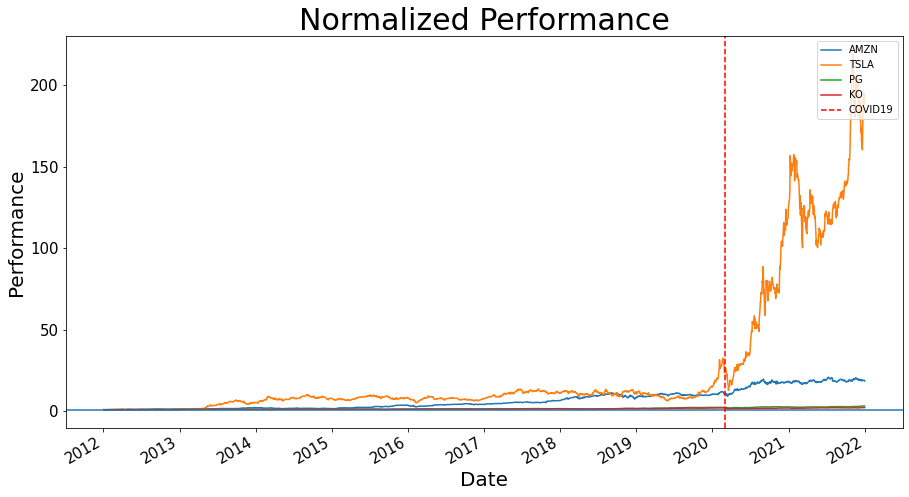

In [17]:
plot_data(norm_df[['AMZN','TSLA','PG','KO']],'Normalized Performance', 'Date', 'Performance')

#### Financial and Real State Companies

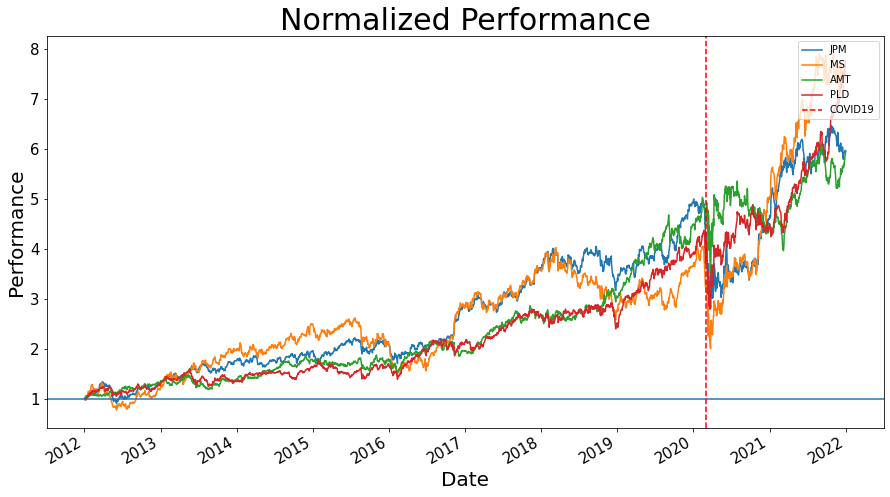

In [18]:
plot_data(norm_df[['JPM', 'MS', 'AMT','PLD']],'Normalized Performance', 'Date', 'Performance')

#### Energy, Industrials and Basic Materials Companies

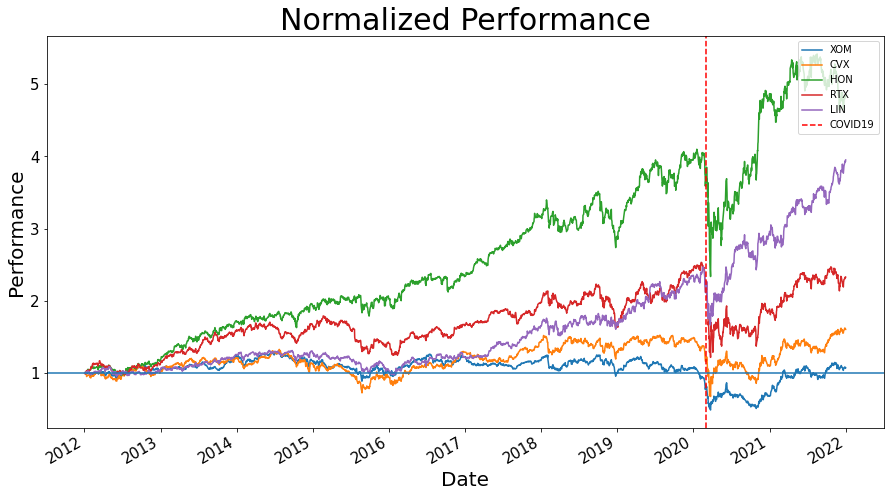

In [19]:
plot_data(norm_df[['XOM','CVX','HON','RTX', 'LIN']],'Normalized Performance', 'Date', 'Performance')

#### Healthcare and Utilities Companies

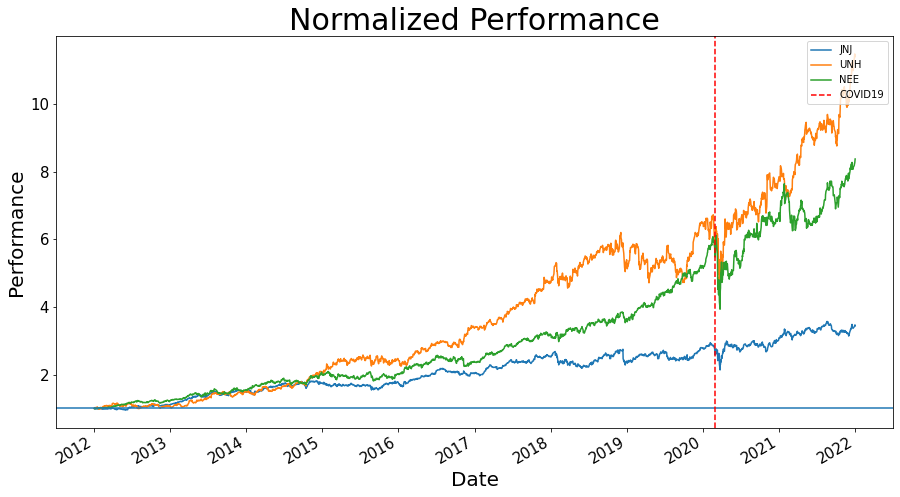

In [20]:
plot_data(norm_df[['JNJ','UNH','NEE']],'Normalized Performance', 'Date', 'Performance')

# Daily Return

In [21]:
d_return = daily_return(stocks, 1)

In [22]:
mean = d_return.describe().loc['mean']
std = d_return.describe().loc['std']

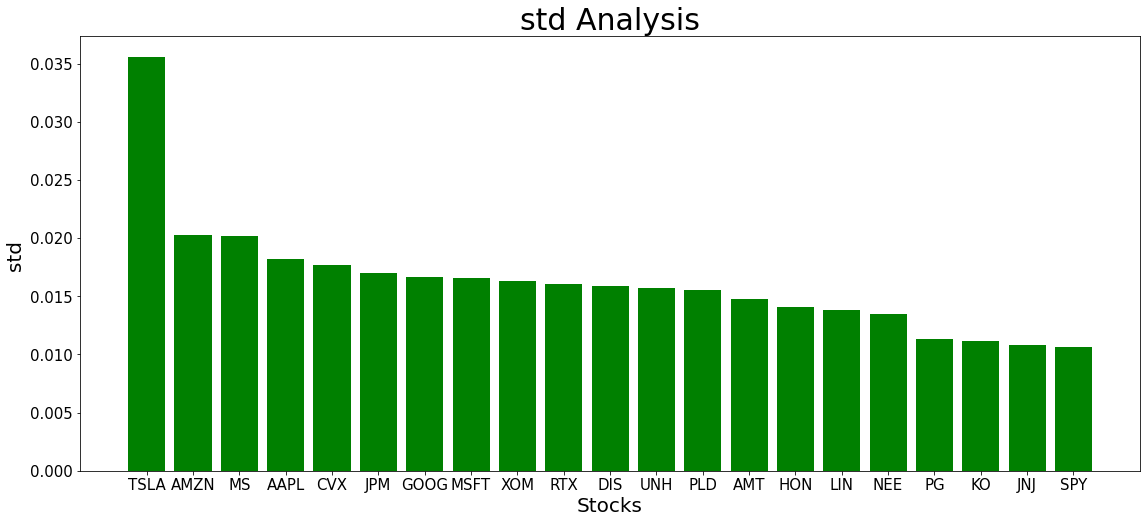

In [23]:
series_analysis(std, 'std')

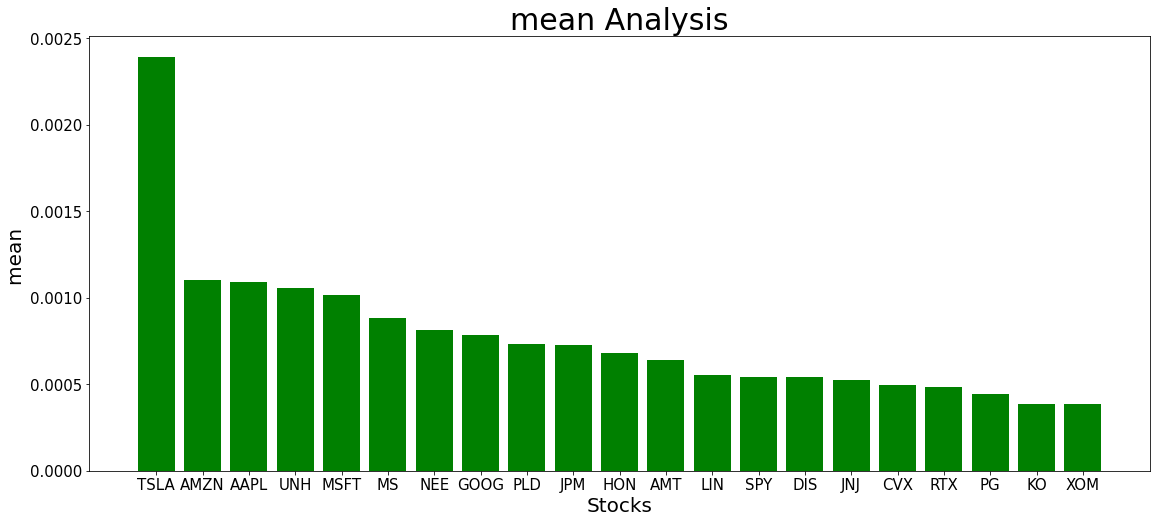

In [24]:
series_analysis(mean, 'mean')

## Daily return behaviour

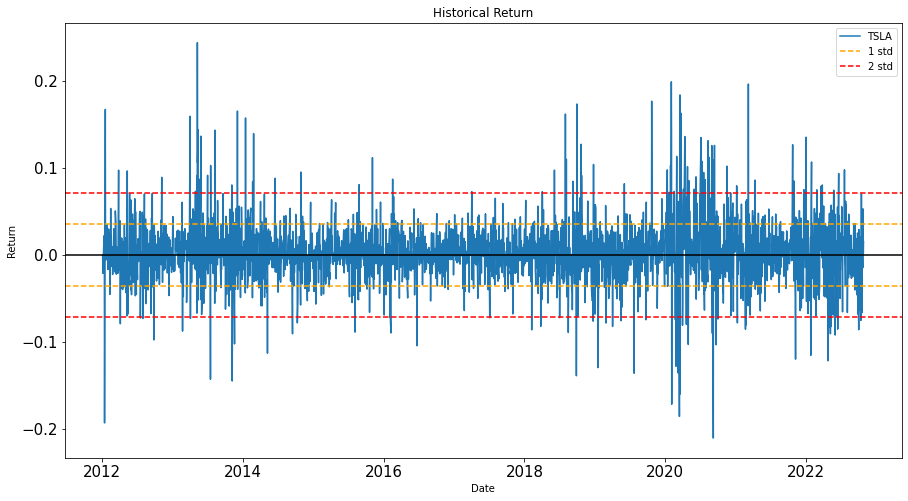

In [25]:
plot_line(d_return['TSLA'])

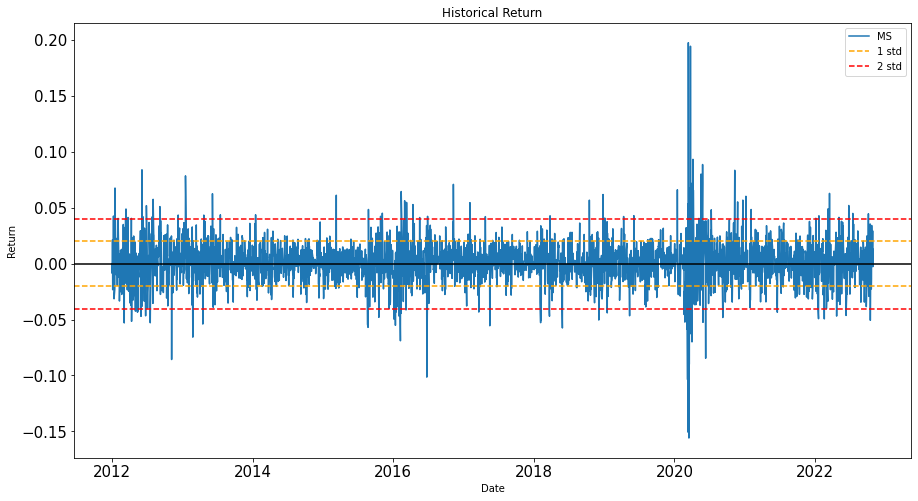

In [26]:
plot_line(d_return['MS'])

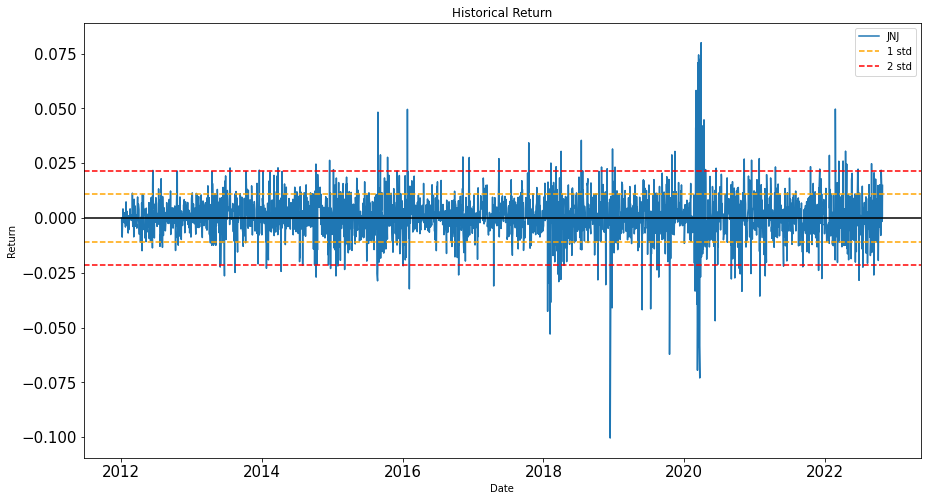

In [27]:
plot_line(d_return['JNJ'])

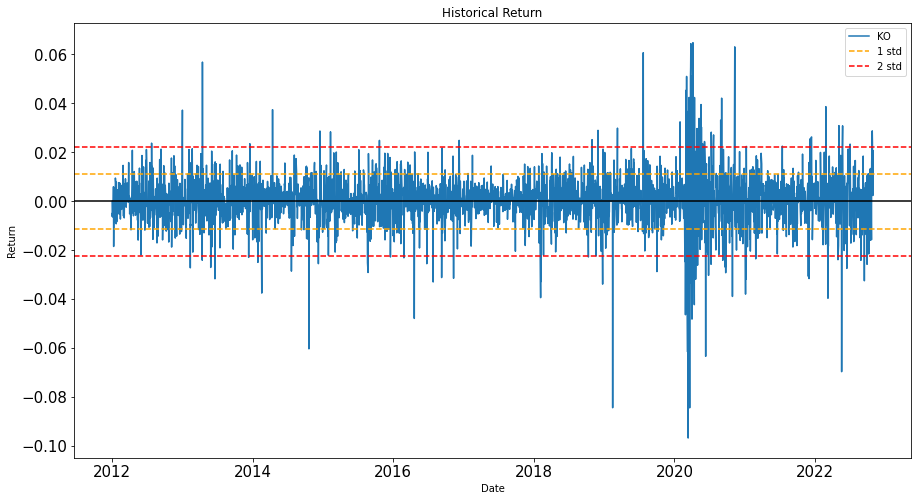

In [28]:
plot_line(d_return['KO'])

## Daily return behaviour - Histogram

The Kurtosis is: 5.587534606210343


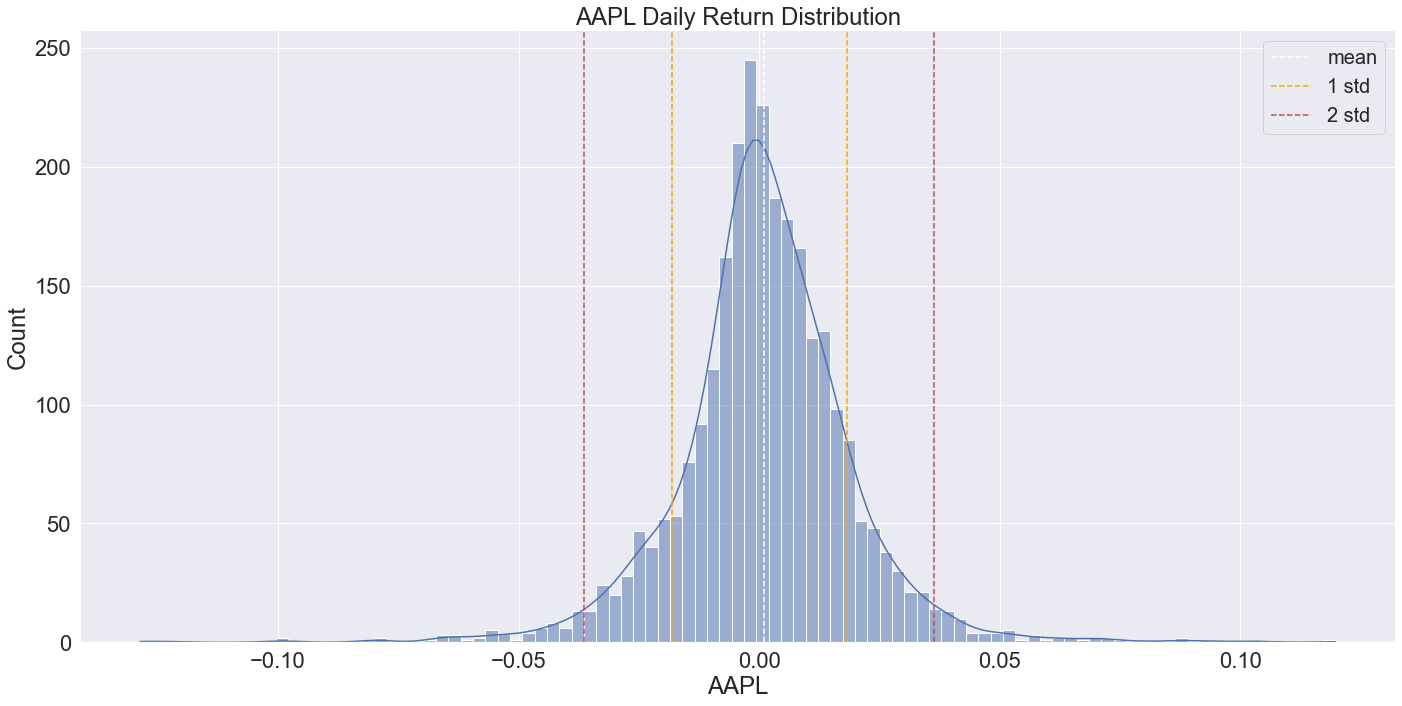

In [29]:
hist_seaborn(d_return['AAPL'])

# Scatter Plots

Beta Coeficient between SPY and JPM is 1.184860912242961
Alpha Coeficient between SPY and JPM is 8.71189208896826e-05


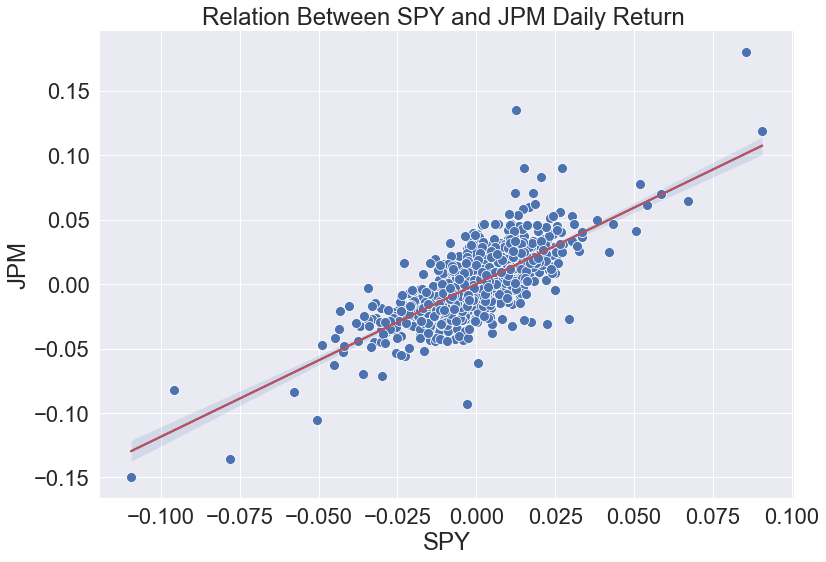

In [30]:
scatter_searborn(d_return, 'SPY', 'JPM')

Beta Coeficient between SPY and JNJ is 0.6122100561065394
Alpha Coeficient between SPY and JNJ is 0.00019659001072189086


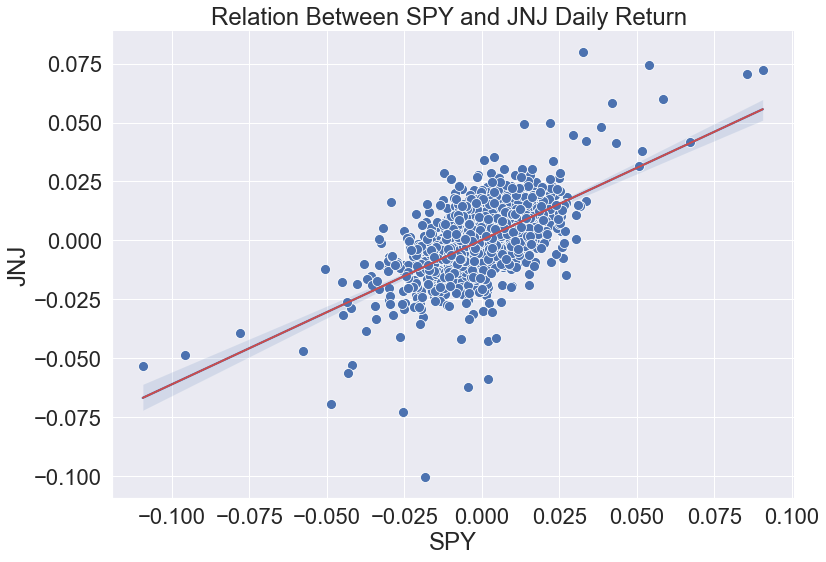

In [31]:
scatter_searborn(d_return, 'SPY', 'JNJ')

# Correlation

In [32]:
d_return_corr = d_return.corr(method='pearson')

<AxesSubplot:>

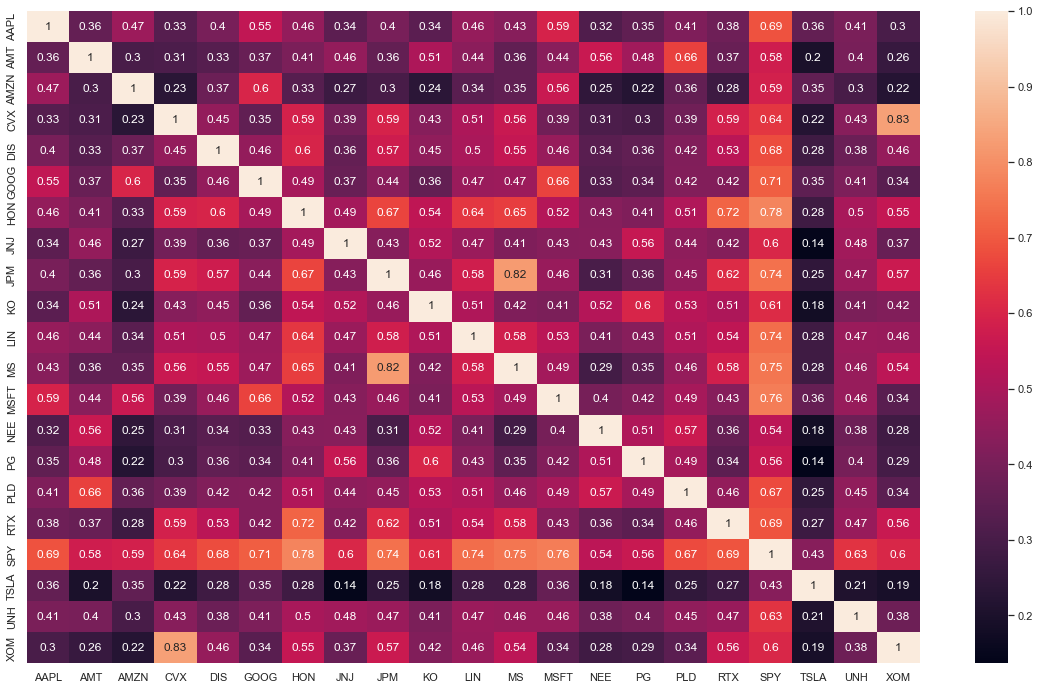

In [33]:
sns.set(rc = {'figure.figsize':(20,12)})
sns.heatmap(d_return_corr, annot=True)

# Technical Analysis

In [34]:
stocks['AAPL'].name

'AAPL'

In [35]:
def SMA_plot(df, n1, n2, n3):
    sma200 = rolling_mean(df, n1)
    sma50 = rolling_mean(df, n2)
    sma10 = rolling_mean(df, n3)
    print(len(df))
    print(len(sma200))
    
    list_sma200 = sma200.values.tolist()
    list_sma50 = sma50.values.tolist()
    list_sma10 = sma10.values.tolist()
    close = df.values.tolist()
    dates = df.index.values
    print(len(list_sma200))
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15) 
    plt.plot(dates, list_sma200, color='red', linestyle='dashed')
    plt.plot(dates, list_sma50, color='orange')
    plt.plot(dates, list_sma10, color='blue')
    plt.scatter(dates, close, s=5, color='green')    
    plt.title(df.name, fontsize='30')
    plt.xlabel('Date', fontsize='20')
    plt.ylabel('Price', fontsize='20')
    print(len(list_sma50))
    print(len(dates)) 

2725
2725
2725
2725
2725


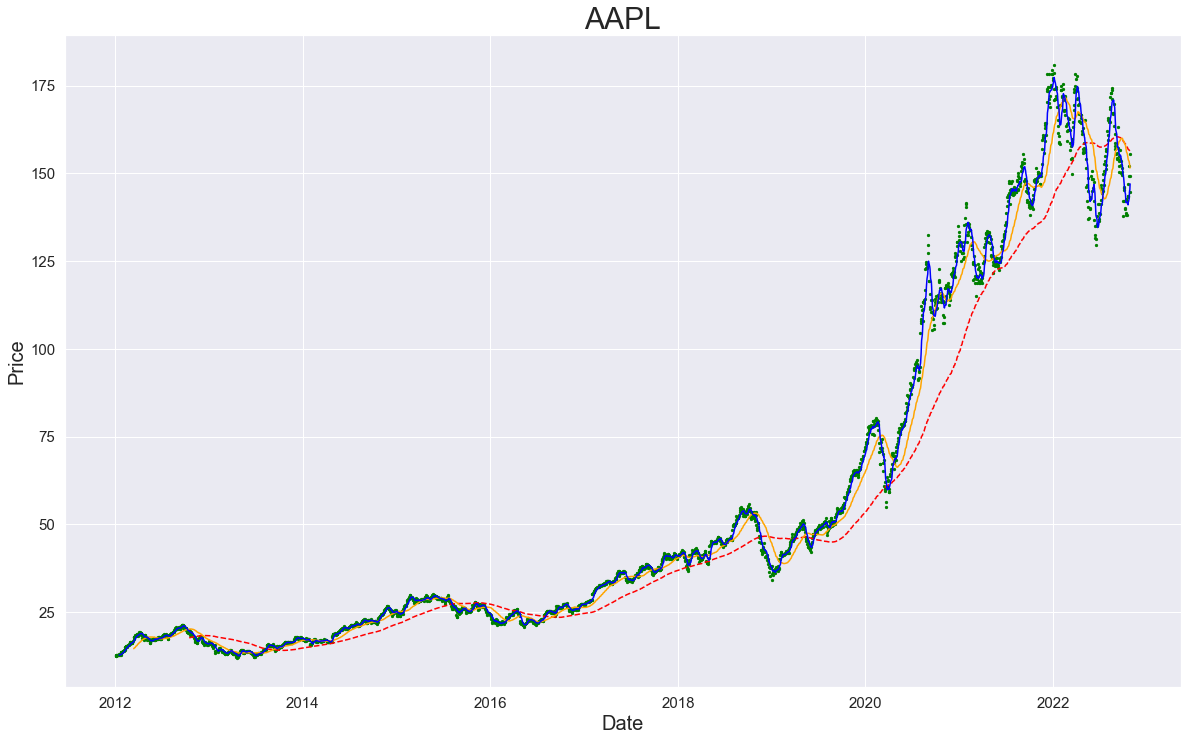

In [36]:
SMA_plot(stocks.AAPL, 200,50,10)

2725
2725
2725
2725
2725


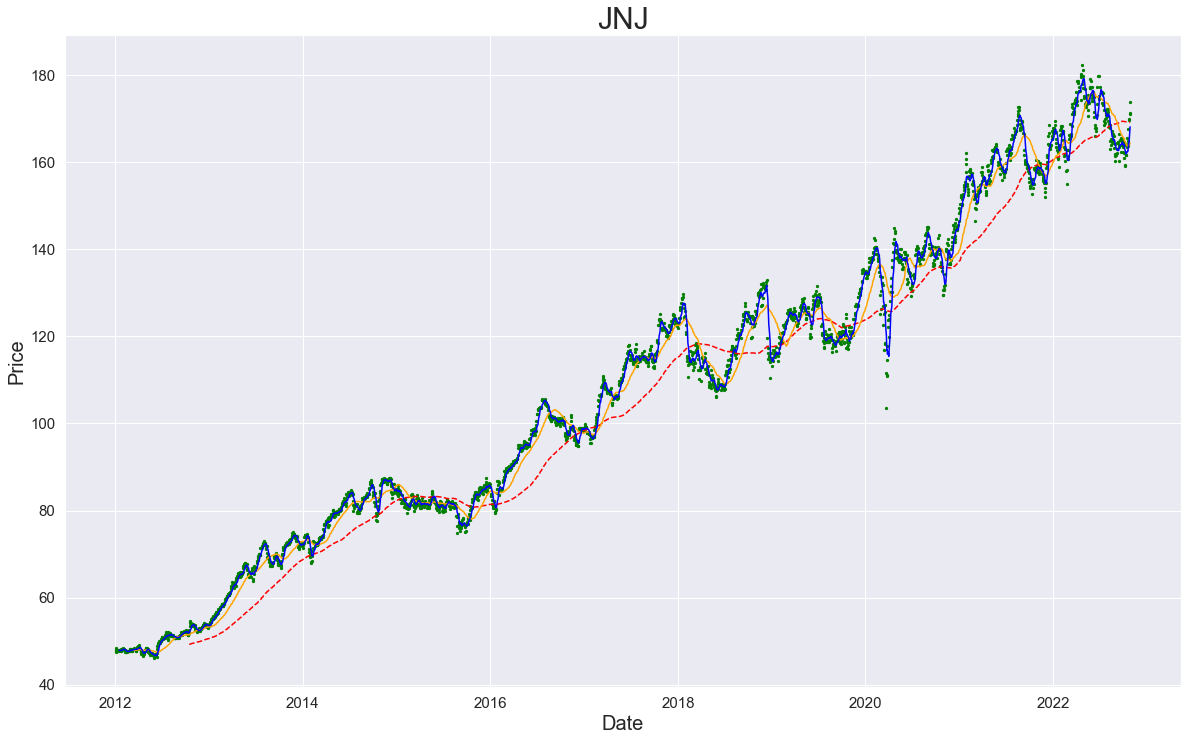

In [37]:
SMA_plot(stocks.JNJ, 200,50,10)

In [38]:
def BB_plot(df, periods, n_std):
    
    sma, upper, lower = bollinger_bands(df, periods, n_std)
    sma_list = sma.values.tolist()
    upper_list = upper.values.tolist()
    lower_list = lower.values.tolist()
    close = df.values.tolist()
    dates = df.index.values       
    plt.plot(dates, upper, color='red', linestyle='dashed')
    plt.plot(dates, lower, color='red', linestyle='dashed')
    plt.plot(dates, sma, color='blue')
    plt.scatter(dates, close, s=5, color='green')    
    plt.title(df.name, fontsize='30')
    plt.xlabel('Date', fontsize='20')
    plt.ylabel('Price', fontsize='20')


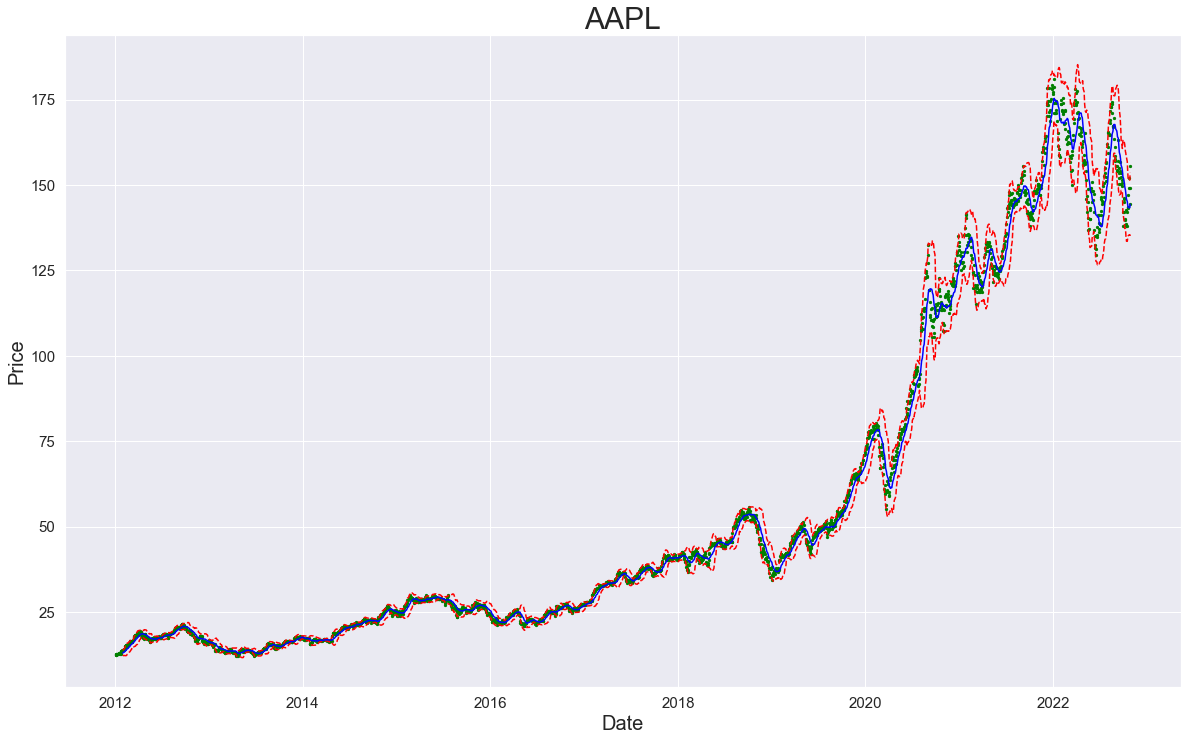

In [39]:
BB_plot(stocks.AAPL, 20, 2)

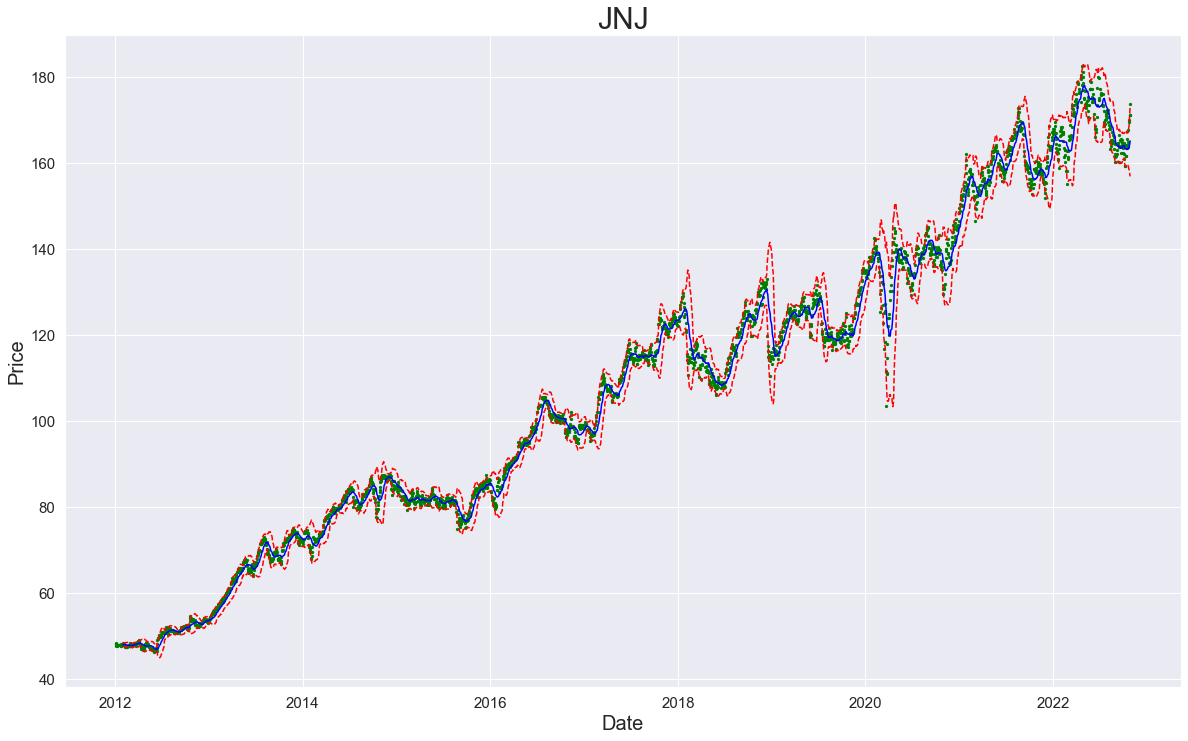

In [40]:
BB_plot(stocks.JNJ, 20, 2)

# Machine Learn

# Linear Regression

In [41]:
data = get_data(['AAPL'], '2012-03-11', '2022-07-10')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-03-12,19.606428,19.714287,19.535713,19.714287,16.804810,407282400
2012-03-13,19.912144,20.292143,19.848213,20.289286,17.294950,690855200
2012-03-14,20.644644,21.240000,20.549999,21.056429,17.948875,1418844000
2012-03-15,21.414642,21.428928,20.662500,20.912857,17.826494,1159718000
2012-03-16,20.882856,21.042856,20.642857,20.913214,17.826799,825487600


In [42]:
# Other Features
data['RSI'] = ta.rsi(data['Adj Close'], lenghth=15)
data['EMAF'] = ta.ema(data['Adj Close'], lenght=20)
data['EMAM'] = ta.ema(data['Adj Close'], lenght=100)
data['EMAS'] = ta.ema(data['Adj Close'], lenght=150)
data['BBupper 2'] = bollinger_bands(data['Adj Close'], 2, 2)[1]
data['BBlower 2'] = bollinger_bands(data['Adj Close'], 2, 2)[2]
#defining Predict as the next Adj Close Price
data['Predict Next Day'] = data['Adj Close'].shift(-1)
data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)

In [43]:
data_set = data.iloc[:, 0:11]#.values
pd.set_option('display.max_columns', None)

data_set.head()

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,BBupper 2,BBlower 2,Predict Next Day
0,21.741785,21.805714,21.355000,18.252394,62.345152,18.307246,18.307246,18.307246,18.853222,17.965443,18.833260
1,21.493929,22.098928,21.442142,18.833260,71.071014,18.402885,18.402885,18.402885,19.364295,17.721358,19.158699
2,22.403570,22.578930,22.232500,19.158699,74.619669,18.540305,18.540305,18.540305,19.456220,18.535738,19.006174
3,22.298214,22.352142,22.035713,19.006174,70.269060,18.625009,18.625009,18.625009,19.298139,18.866734,19.291437
4,22.392143,22.666430,22.264286,19.291437,73.393511,18.746178,18.746178,18.746178,19.552229,18.745383,19.369068


In [44]:
# Feature Scaling
sc = MinMaxScaler(feature_range=(0,1)) #will rescale the values between 0 and 1
data_set_scaled = sc.fit_transform(data_set)

data_set_scaled

array([[0.04672353, 0.04466917, 0.04596718, ..., 0.03875671, 0.03716415,
        0.04007619],
       [0.04525496, 0.04640757, 0.04649415, ..., 0.04171361, 0.03569722,
        0.04200306],
       [0.05064466, 0.0492534 , 0.05127359, ..., 0.04224546, 0.04059157,
        0.04109998],
       ...,
       [0.73420066, 0.75496323, 0.7448696 , ..., 0.76007531, 0.74720418,
        0.77219972],
       [0.75541247, 0.76984446, 0.76996544, ..., 0.76122259, 0.76991909,
        0.79244652],
       [0.76690706, 0.78425145, 0.78326921, ..., 0.79192296, 0.76672876,
        0.79651935]])

In [45]:
x_train, x_test, y_train, y_test = train_test_split_custom(data_set_scaled, .8)

In [46]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2067, 10)
(2067,)
(517, 10)
(517,)


In [47]:
# Create Model
regressor = LinearRegression()
# Fit model
regressor.fit(x_train, y_train)
# Prediction
y_pred = regressor.predict(x_test)

In [48]:
# Parameters of the model
regressor.score(x_train,y_train)
regressor.coef_
regressor.intercept_

print(f'Score :{regressor.score(x_train,y_train)} | \
Coeficients: {regressor.coef_} | Intercept: {regressor.intercept_}')

Score :0.9980262479183517 | Coeficients: [-0.19043081  0.15751263 -0.00340709  0.53942277  0.00109114 -0.00380474
 -0.00380474 -0.00380474  0.22017157  0.28965011] | Intercept: -0.00037434703282779314


In [49]:
# Compare y_pred and y_test
compared = np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test),1)),1) 
print(compared)

[[0.44253775 0.43828557]
 [0.43973983 0.45162181]
 [0.45002226 0.4627862 ]
 ...
 [0.76391065 0.77219972]
 [0.77326833 0.79244652]
 [0.79004101 0.79651935]]


In [50]:
# RMSE
linmodel_MSE = mean_squared_error(y_test, y_pred, squared=True)
linmodel_MSE

0.00026198279002849625

In [51]:
for i in range(50):
    print(y_pred[i], y_test[i], f'Predictions accuracy {round(float((y_pred[i] / y_test[i] - 1) * 100), 2)}% of actual value')

0.44253775291477226 0.438285569021056 Predictions accuracy 0.97% of actual value
0.43973983289480445 0.4516218074647147 Predictions accuracy -2.63% of actual value
0.45002226258445155 0.46278620358837663 Predictions accuracy -2.76% of actual value
0.461898598113082 0.4533561553927906 Predictions accuracy 1.88% of actual value
0.45621090897378735 0.46032295431718906 Predictions accuracy -0.89% of actual value
0.45994338950087577 0.4439844247253377 Predictions accuracy 3.59% of actual value
0.44659496581632596 0.45586308634461703 Predictions accuracy -2.03% of actual value
0.45482613490873947 0.4602646367890558 Predictions accuracy -1.18% of actual value
0.4610902928118912 0.45925905468698536 Predictions accuracy 0.4% of actual value
0.46064071162647335 0.45925905468698536 Predictions accuracy 0.3% of actual value
0.4604370213685606 0.4734551491709348 Predictions accuracy -2.75% of actual value
0.47075582728730914 0.4717644377511291 Predictions accuracy -0.21% of actual value
0.473495783

<AxesSubplot:>

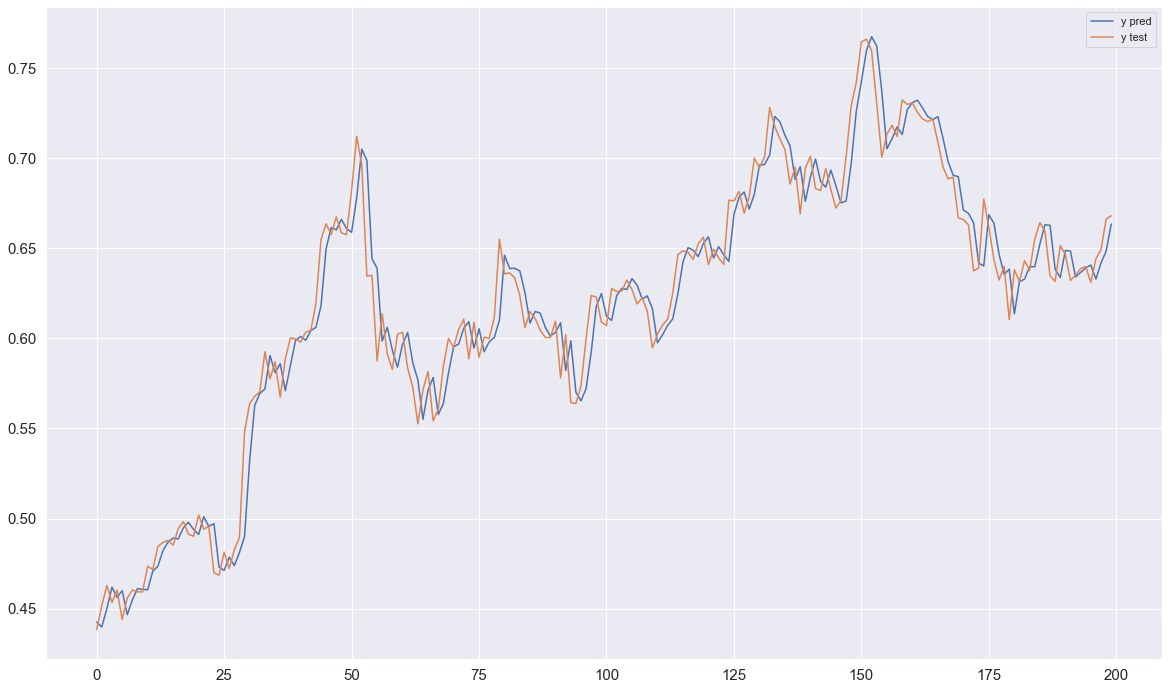

In [52]:
df = pd.DataFrame(compared, columns=['y pred', 'y test'])
df.iloc[0:200,:].plot()

# KNN

In [53]:
#Create Model
knn = KNeighborsRegressor(n_neighbors=2)
# Fit Model
knn.fit(x_train, y_train)
# Predict
knn_ypred = knn.predict(x_test)

In [54]:
# Compare y_pred with y_test
knn_compared = np.concatenate((knn_ypred.reshape(len(knn_ypred), 1), y_test.reshape(len(y_test),1)),1)
knn_compared

array([[0.44111313, 0.43828557],
       [0.44111313, 0.45162181],
       [0.44111313, 0.4627862 ],
       ...,
       [0.44111313, 0.77219972],
       [0.44111313, 0.79244652],
       [0.44111313, 0.79651935]])

<AxesSubplot:>

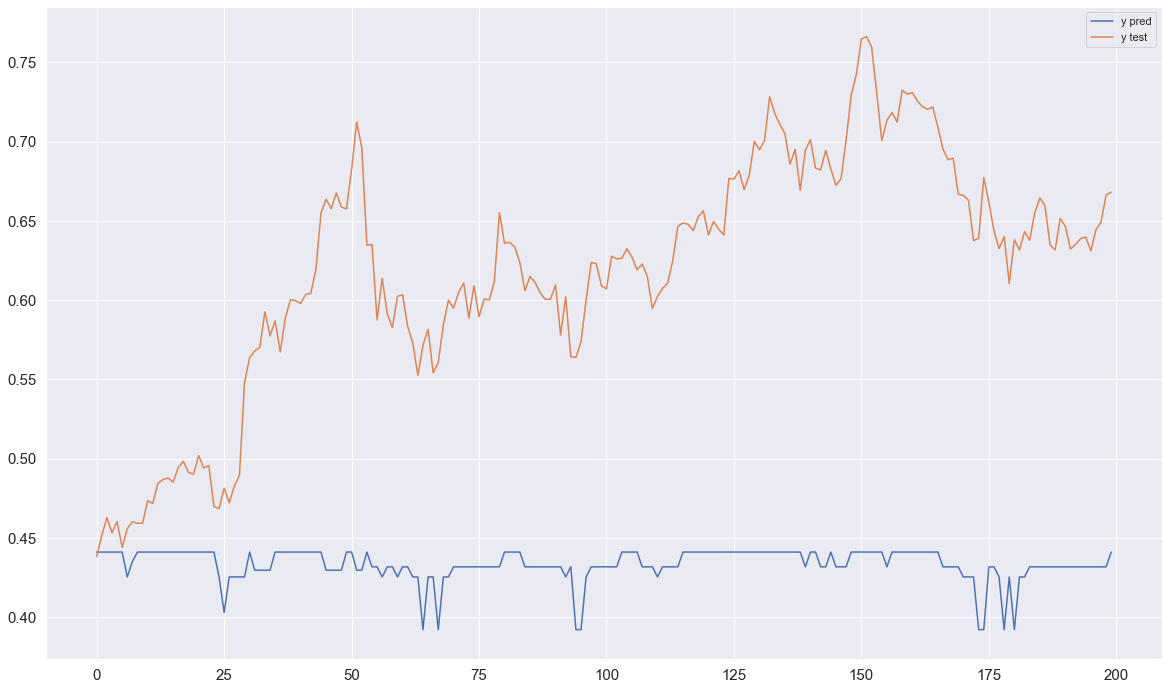

In [55]:
knn_df = pd.DataFrame(knn_compared, columns=['y pred', 'y test'])
knn_df.iloc[0:200,:].plot()

In [56]:
for i in range(50):
    print(knn_ypred[i], y_test[i], f'Predictions accuracy {round(float((knn_ypred[i] / y_test[i] - 1) * 100), 2)}% of actual value')

0.441113133446693 0.438285569021056 Predictions accuracy 0.65% of actual value
0.441113133446693 0.4516218074647147 Predictions accuracy -2.33% of actual value
0.441113133446693 0.46278620358837663 Predictions accuracy -4.68% of actual value
0.441113133446693 0.4533561553927906 Predictions accuracy -2.7% of actual value
0.441113133446693 0.46032295431718906 Predictions accuracy -4.17% of actual value
0.441113133446693 0.4439844247253377 Predictions accuracy -0.65% of actual value
0.4254230983814723 0.45586308634461703 Predictions accuracy -6.68% of actual value
0.4351008944337946 0.4602646367890558 Predictions accuracy -5.47% of actual value
0.441113133446693 0.45925905468698536 Predictions accuracy -3.95% of actual value
0.441113133446693 0.45925905468698536 Predictions accuracy -3.95% of actual value
0.441113133446693 0.4734551491709348 Predictions accuracy -6.83% of actual value
0.441113133446693 0.4717644377511291 Predictions accuracy -6.5% of actual value
0.441113133446693 0.48441

In [57]:
knn_MSE = mean_squared_error(y_test, knn_ypred, squared=True)
knn_MSE

0.10840785382129312

# LSTM

In [58]:
# Prepare Data
X = []
n_features = len(data_set.columns)
back_days = 50
print(data_set_scaled.shape[0])
for j in range(n_features):
    X.append([])
    for i in range(back_days, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-back_days:i, j])


X=np.moveaxis(X, [0], [2])


X, yi =np.array(X), np.array(data_set_scaled[back_days:,-1])
y=np.reshape(yi,(len(yi),1))



2584


In [59]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
X_train.shape

2027


(2027, 50, 11)

In [60]:
# Create model
lstm_input = Input(shape=(back_days, n_features), name='lstm_input')
inputs = LSTM(200, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
# Fit Model
model.fit(x=X_train, y=y_train, batch_size=15, epochs=10, shuffle=True, validation_split = 0.1)
#Predict 
lstm_ypred = model.predict(X_test)

Epoch 1/10
122/122 [==============================] - 6s 33ms/step - loss: 2.3530e-04 - val_loss: 3.9210e-04
Epoch 2/10
122/122 [==============================] - 4s 29ms/step - loss: 3.5140e-05 - val_loss: 3.4657e-04
Epoch 3/10
122/122 [==============================] - 4s 29ms/step - loss: 2.9158e-05 - val_loss: 2.2468e-04
Epoch 4/10
122/122 [==============================] - 4s 29ms/step - loss: 3.3308e-05 - val_loss: 5.5619e-04
Epoch 5/10
122/122 [==============================] - 4s 30ms/step - loss: 3.7768e-05 - val_loss: 2.1331e-04
Epoch 6/10
122/122 [==============================] - 4s 29ms/step - loss: 3.3853e-05 - val_loss: 2.0941e-04
Epoch 7/10
122/122 [==============================] - 4s 30ms/step - loss: 2.4494e-05 - val_loss: 2.5078e-04
Epoch 8/10
122/122 [==============================] - 4s 29ms/step - loss: 2.5600e-05 - val_loss: 1.9076e-04
Epoch 9/10
122/122 [==============================] - 4s 29ms/step - loss: 2.6577e-05 - val_loss: 2.0166e-04
Epoch 10/10
16/16 [

In [61]:
for i in range(50):
    print(lstm_ypred[i], y_test[i], f'Predictions accuracy {round(float((lstm_ypred[i] / y_test[i] - 1) * 100), 2)}% of actual value')

[0.4552767] [0.47345515] Predictions accuracy -3.84% of actual value
[0.4578386] [0.47176444] Predictions accuracy -2.95% of actual value
[0.46460104] [0.48441555] Predictions accuracy -4.09% of actual value
[0.4681701] [0.48680589] Predictions accuracy -3.83% of actual value
[0.47474864] [0.48778238] Predictions accuracy -2.67% of actual value
[0.4796588] [0.48520259] Predictions accuracy -1.14% of actual value
[0.48239842] [0.494414] Predictions accuracy -2.43% of actual value
[0.48474094] [0.49830555] Predictions accuracy -2.72% of actual value
[0.4882875] [0.49129498] Predictions accuracy -0.61% of actual value
[0.4929632] [0.49015808] Predictions accuracy 0.57% of actual value
[0.49029568] [0.50199297] Predictions accuracy -2.33% of actual value
[0.49005157] [0.49407873] Predictions accuracy -0.82% of actual value
[0.4944177] [0.49566753] Predictions accuracy -0.25% of actual value
[0.49312383] [0.46985505] Predictions accuracy 4.95% of actual value
[0.49195918] [0.4685142] Predic

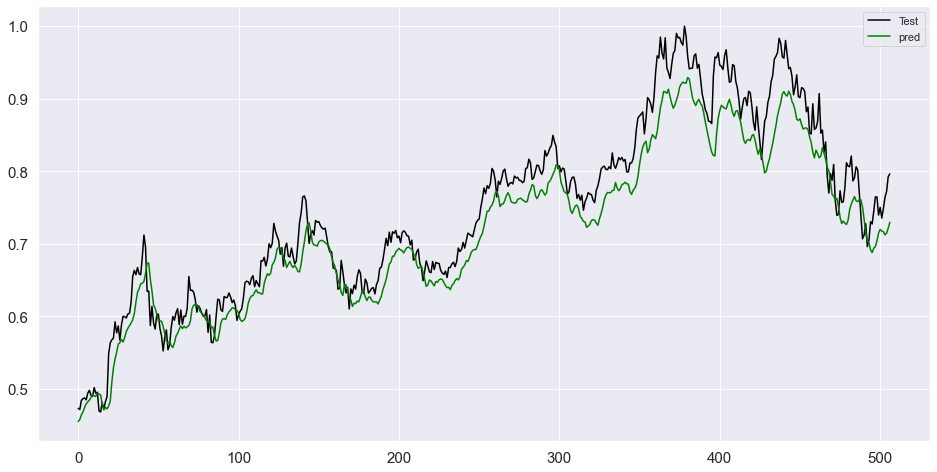

In [62]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(lstm_ypred, color = 'green', label = 'pred')
plt.legend()
plt.show()

In [63]:
lstmmodel_MSE = mean_squared_error(y_test, lstm_ypred, squared=True)
lstmmodel_MSE

0.0016039466217292726

In [64]:
print(('Linear Model MSE', linmodel_MSE))
print(('LSTM Model MSE', lstmmodel_MSE))
print(('KNN Model MSE', knn_MSE))

('Linear Model MSE', 0.00026198279002849625)
('LSTM Model MSE', 0.0016039466217292726)
('KNN Model MSE', 0.10840785382129312)


### The Linear model shows the better result by avaluating the MSE compared to the LSTM model and the KNN model.

# Improvements

In [65]:
data2 = get_data(['AAPL'], '2012-03-11', '2022-07-10')
# Other Features
data2['RSI'] = ta.rsi(data2['Adj Close'], lenghth=15)
data2['EMAF'] = ta.ema(data2['Adj Close'], lenght=20)
data2['EMAM'] = ta.ema(data2['Adj Close'], lenght=100)
data2['EMAS'] = ta.ema(data2['Adj Close'], lenght=150)
data2['BBupper 2'] = bollinger_bands(data2['Adj Close'], 2, 2)[1]
data2['BBlower 2'] = bollinger_bands(data2['Adj Close'], 2, 2)[2]
#defining Predict as the next Adj Close Price
data2['Predict Next Day'] = data2['Adj Close'].shift(-1)
data2.dropna(inplace=True)
data2.reset_index(inplace=True)
data2.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)

data2_set = data2.iloc[:, 0:11]#.values
pd.set_option('display.max_columns', None)
# Feature Scaling
sc = MinMaxScaler(feature_range=(0,1)) #will rescale the values between 0 and 1
data2_set_scaled = sc.fit_transform(data2_set)
# Split
x_train, x_test, y_train, y_test = train_test_split_custom(data2_set_scaled, .8)

[*********************100%***********************]  1 of 1 completed


## KNN

<AxesSubplot:>

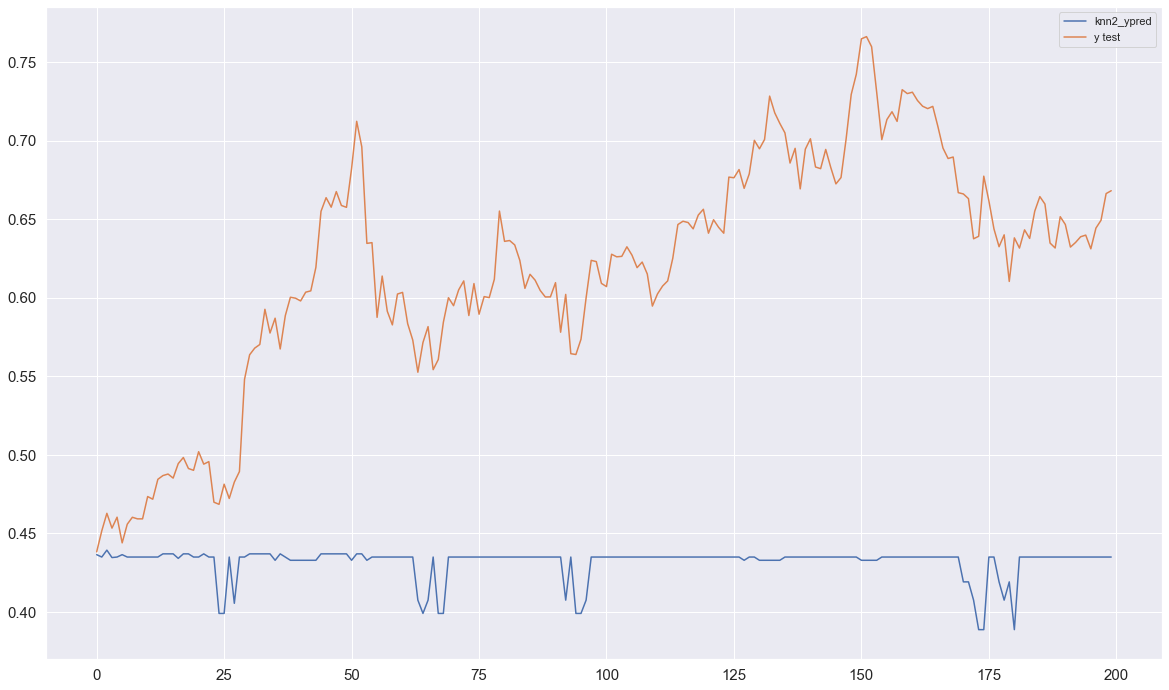

In [66]:
#Create Model
knn2 = KNeighborsRegressor(n_neighbors=5)
# Fit Model
knn2.fit(x_train, y_train)
# Predict
knn2_ypred = knn2.predict(x_test)

knn2_compared = np.concatenate((knn2_ypred.reshape(len(knn2_ypred), 1), y_test.reshape(len(y_test),1)),1)
knn2_df = pd.DataFrame(knn2_compared, columns=['knn2_ypred', 'y test'])
knn2_df.iloc[0:200,:].plot()

In [67]:
knn2_MSE = mean_squared_error(y_test, knn2_ypred, squared=True)

# LSTM

In [72]:
# Prepare Data
X = []
n_features = len(data_set.columns)
back_days = 50
print(data_set_scaled.shape[0])
for j in range(n_features):
    X.append([])
    for i in range(back_days, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-back_days:i, j])


X=np.moveaxis(X, [0], [2])


X, yi =np.array(X), np.array(data_set_scaled[back_days:,-1])
y=np.reshape(yi,(len(yi),1))

# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
X_train.shape

# Create model
lstm_input = Input(shape=(back_days, n_features), name='lstm_input')
inputs = LSTM(100, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
# Fit Model
model.fit(x=X_train, y=y_train, batch_size=15, epochs=100, shuffle=True, validation_split = 0.1)
#Predict 
lstm_ypred2 = model.predict(X_test)

2584
2027
Epoch 1/100
122/122 [==============================] - 5s 21ms/step - loss: 3.5588e-04 - val_loss: 4.9415e-04
Epoch 2/100
122/122 [==============================] - 2s 17ms/step - loss: 3.5812e-05 - val_loss: 3.0512e-04
Epoch 3/100
122/122 [==============================] - 2s 17ms/step - loss: 3.8596e-05 - val_loss: 2.8535e-04
Epoch 4/100
122/122 [==============================] - 2s 17ms/step - loss: 3.5489e-05 - val_loss: 2.5025e-04
Epoch 5/100
122/122 [==============================] - 2s 17ms/step - loss: 3.4179e-05 - val_loss: 3.2153e-04
Epoch 6/100
122/122 [==============================] - 2s 17ms/step - loss: 3.1125e-05 - val_loss: 4.5072e-04
Epoch 7/100
122/122 [==============================] - 2s 17ms/step - loss: 3.2280e-05 - val_loss: 2.1596e-04
Epoch 8/100
122/122 [==============================] - 2s 17ms/step - loss: 2.9319e-05 - val_loss: 3.3870e-04
Epoch 9/100
122/122 [==============================] - 2s 17ms/step - loss: 3.0920e-05 - val_loss: 1.8372e-04


Epoch 75/100
122/122 [==============================] - 2s 17ms/step - loss: 1.1762e-05 - val_loss: 1.8344e-04
Epoch 76/100
122/122 [==============================] - 2s 17ms/step - loss: 1.2825e-05 - val_loss: 1.6041e-04
Epoch 77/100
122/122 [==============================] - 2s 17ms/step - loss: 1.2322e-05 - val_loss: 2.1139e-04
Epoch 78/100
122/122 [==============================] - 2s 17ms/step - loss: 1.6756e-05 - val_loss: 1.5784e-04
Epoch 79/100
122/122 [==============================] - 2s 17ms/step - loss: 1.1388e-05 - val_loss: 1.4916e-04
Epoch 80/100
122/122 [==============================] - 2s 17ms/step - loss: 1.0354e-05 - val_loss: 1.4416e-04
Epoch 81/100
122/122 [==============================] - 2s 17ms/step - loss: 1.1374e-05 - val_loss: 1.4530e-04
Epoch 82/100
122/122 [==============================] - 2s 17ms/step - loss: 1.1186e-05 - val_loss: 1.4612e-04
Epoch 83/100
122/122 [==============================] - 2s 17ms/step - loss: 1.1992e-05 - val_loss: 1.8115e-04
E

In [73]:
lstmmodel2_MSE = mean_squared_error(y_test, lstm_ypred2, squared=True)

In [74]:
print(('LSTM Model 2 MSE', lstmmodel2_MSE))
print(('LSTM Model MSE', lstmmodel_MSE))

('LSTM Model 2 MSE', 0.00038852817435987324)
('LSTM Model MSE', 0.0016039466217292726)


### The improvement made on the LSTM model by increasing the number of epochs shows favorable results by decreasing the MSE compared to the first LSTM model. This indicates that other tunes in the model can probably result in a more effective model. Another way to get better performance is to add other features to the model.